In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
# from scanpy.plotting._tools.scatterplots import plot_scatter
import seaborn as sns
from pyscenic.utils import load_motifs
import operator as op
from IPython.display import HTML, display
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [2]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.7.2
sinfo       0.3.4
-----
MulticoreTSNE       NA
PIL                 8.4.0
adjustText          NA
attr                21.4.0
backcall            0.2.0
boltons             NA
cached_property     1.5.2
cffi                1.14.6
cloudpickle         2.0.0
ctxcore             0.1.1
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.0
dateutil            2.8.2
decorator           4.4.2
entrypoints         0.3
frozendict   

In [3]:
adata = sc.read( './pySCENIC_out.loom', validate=False)

# drop the embeddings and extra attributes from the obs object
# adata.obs.drop( ['Embedding','Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [4]:
sc._utils.sanitize_anndata( adata )
adata

... storing 'sample' as categorical
... storing 'subtype' as categorical
... storing 'treatment' as categorical


AnnData object with n_obs × n_vars = 526 × 23322
    obs: 'RegulonsAUC', 'nGene', 'nUMI', 'sample', 'subtype', 'treatment'
    var: 'Regulons'

In [ ]:

BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 200)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [6]:
df_motifs = load_motifs('./reg.csv')

In [7]:
selected_motifs = ['PAX5','TCF3','EBF1','STAT1']
df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]
display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(9))

NameError: name 'display_logos' is not defined

In [45]:
# need do scanpt analysis first
sc.set_figure_params(frameon=False, dpi=600, fontsize=10, dpi_save=600)

# sc.pl.scatter( adata, basis='highly_variable_genes_UMAP', 
#     color=['Louvain_clusters_Scanpy','Celltype_Garnett'],
#     title=['HVG - UMAP (Louvain clusters)','HVG - UMAP (Cell type)'],
#     alpha=0.8,
#     save='_Louvain-celltype.pdf'
#     )

# sc.pl.scatter( adata, basis='SCENIC_AUC_UMAP', 
#     color=['Louvain_clusters_Scanpy','Celltype_Garnett'],
#     title=['SCENIC - UMAP (Louvain clusters)','SCENIC - UMAP (Cell type)'], 
#     alpha=0.8,
#     save='_Louvain-celltype.pdf'
#     )

In [47]:
lf = lp.connect( './pySCENIC_out.loom', mode='r', validate=False )
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

cellAnnot = pd.concat(
    [
        pd.DataFrame( lf.ca.subtype, index=lf.ca.CellID ),
        # pd.DataFrame( lf.ca.ClusterID, index=lf.ca.CellID ),
        # pd.DataFrame( lf.ca.Louvain_clusters_Scanpy, index=lf.ca.CellID ),
        # pd.DataFrame( lf.ca.Percent_mito, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.treatment, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'subtype',
 # 'ClusterID',
 # 'Louvain_clusters_Scanpy',
 # 'Percent_mito',
 'nGene',
 'nUMI',
 'treatment']
lf.close()
# rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['treatment'] )
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['subtype'] )
rss_cellType



,AHCTF1(+),ARID3A(+),ARNT(+),ARNTL(+),ATF1(+),ATF2(+),ATF3(+),ATF4(+),ATF5(+),ATF6(+),...,ZNF594(+),ZNF623(+),ZNF664(+),ZNF699(+),ZNF740(+),ZNF75D(+),ZNF76(+),ZNF790(+),ZNF84(+),ZNF91(+)
unknown,0.570655,0.719603,0.775588,0.780898,0.927848,0.477357,0.880022,0.924926,0.436191,0.912542,...,0.887355,0.456444,0.664328,0.304009,0.698389,0.302264,0.927505,0.340459,0.790367,0.877927


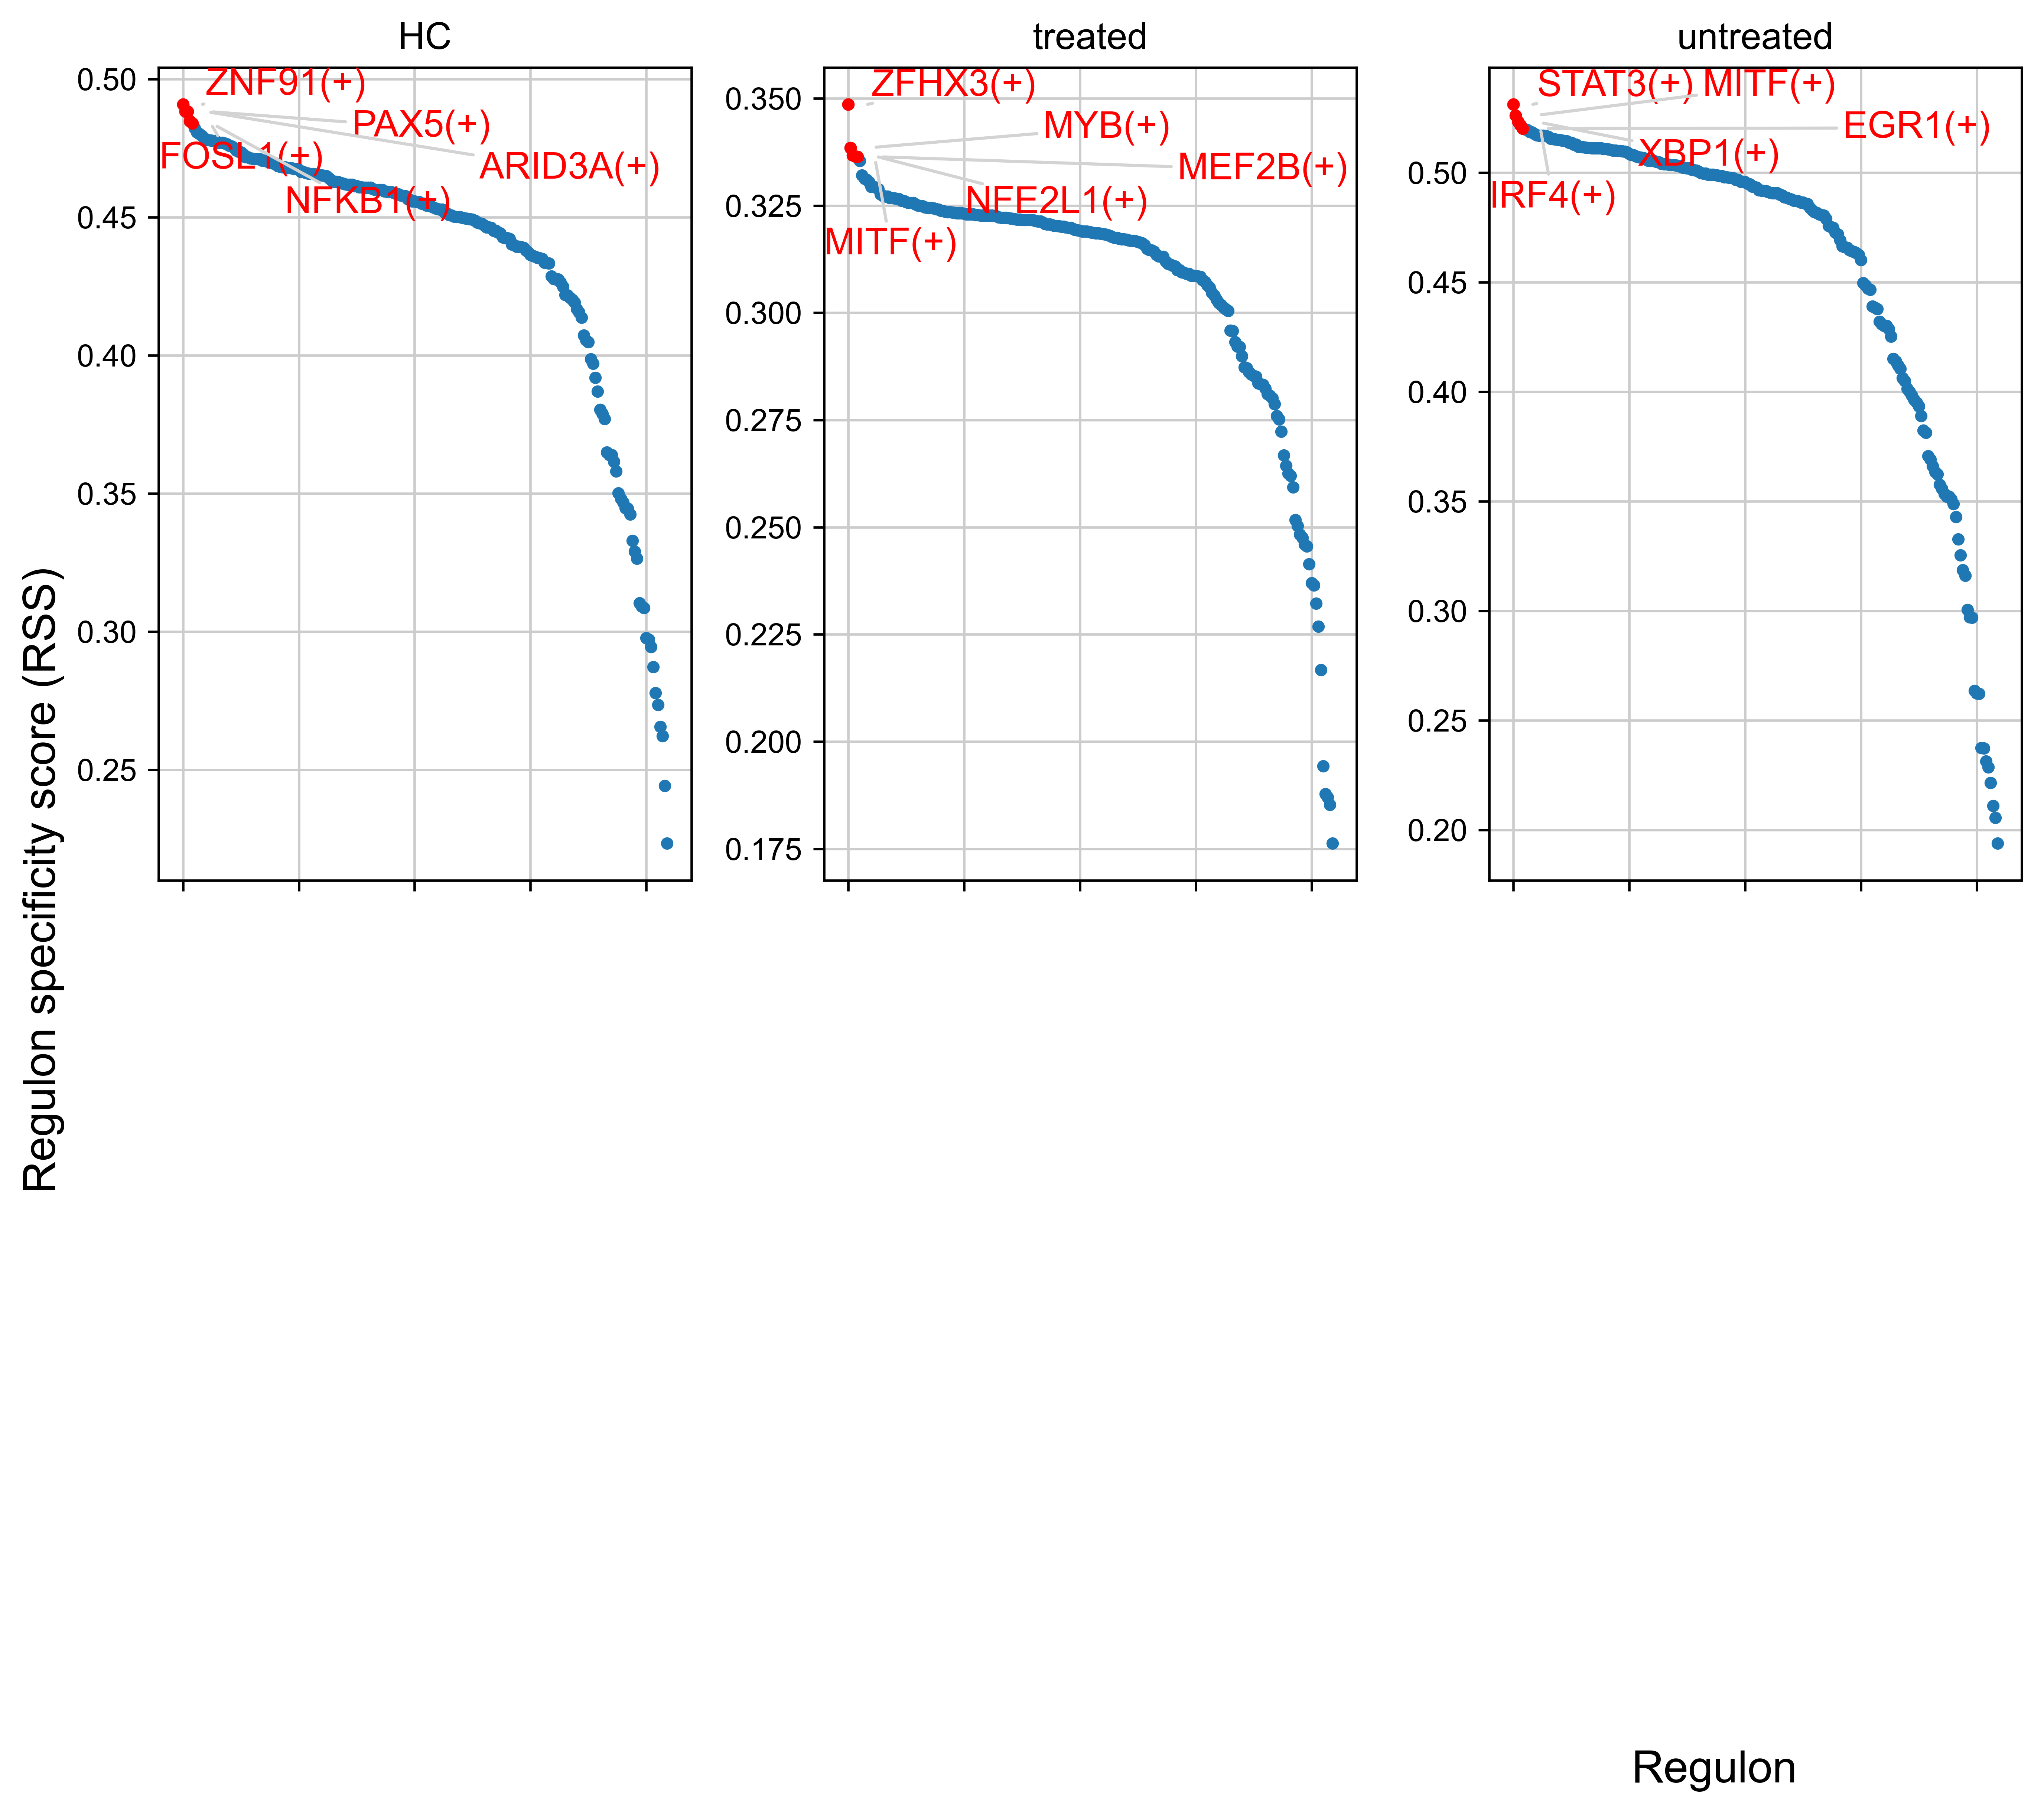

In [24]:
cats = sorted(list(set(cellAnnot['treatment'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,5,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("PBMC10k_cellType-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

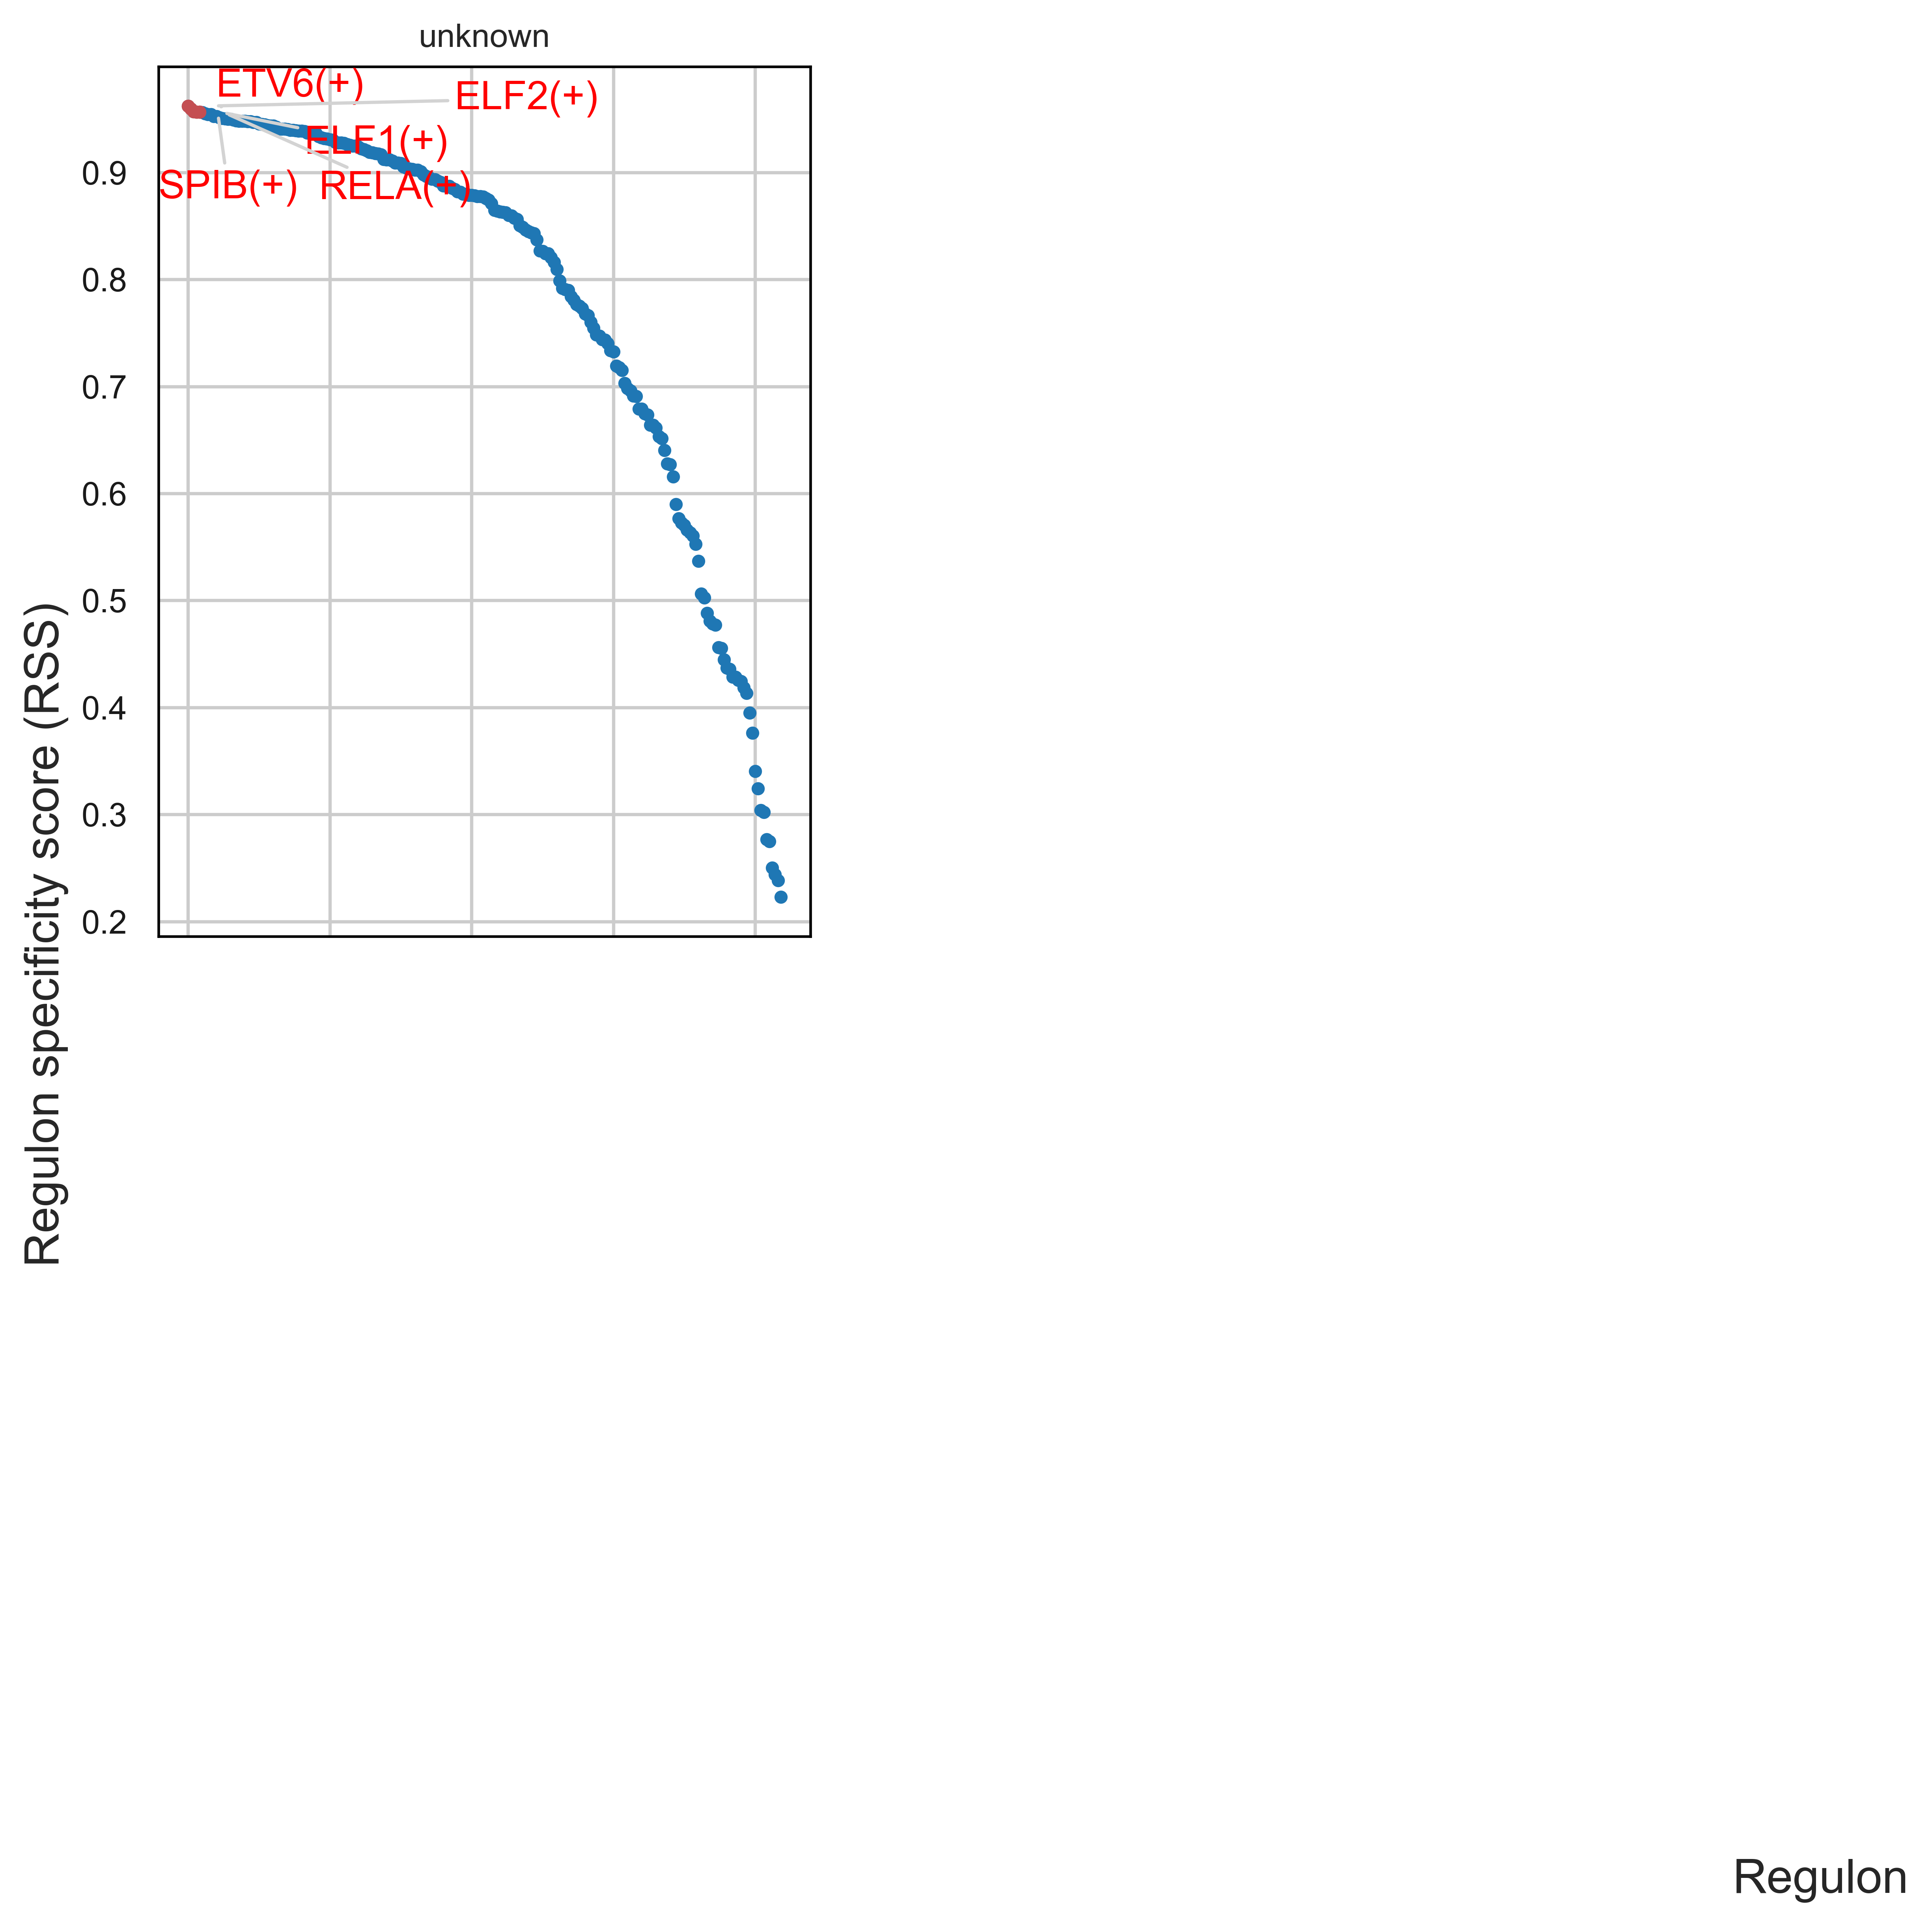

In [48]:
cats = sorted(list(set(cellAnnot['subtype'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,5,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })

plt.show()

In [25]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [26]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

In [27]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [29]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['treatment'] ]

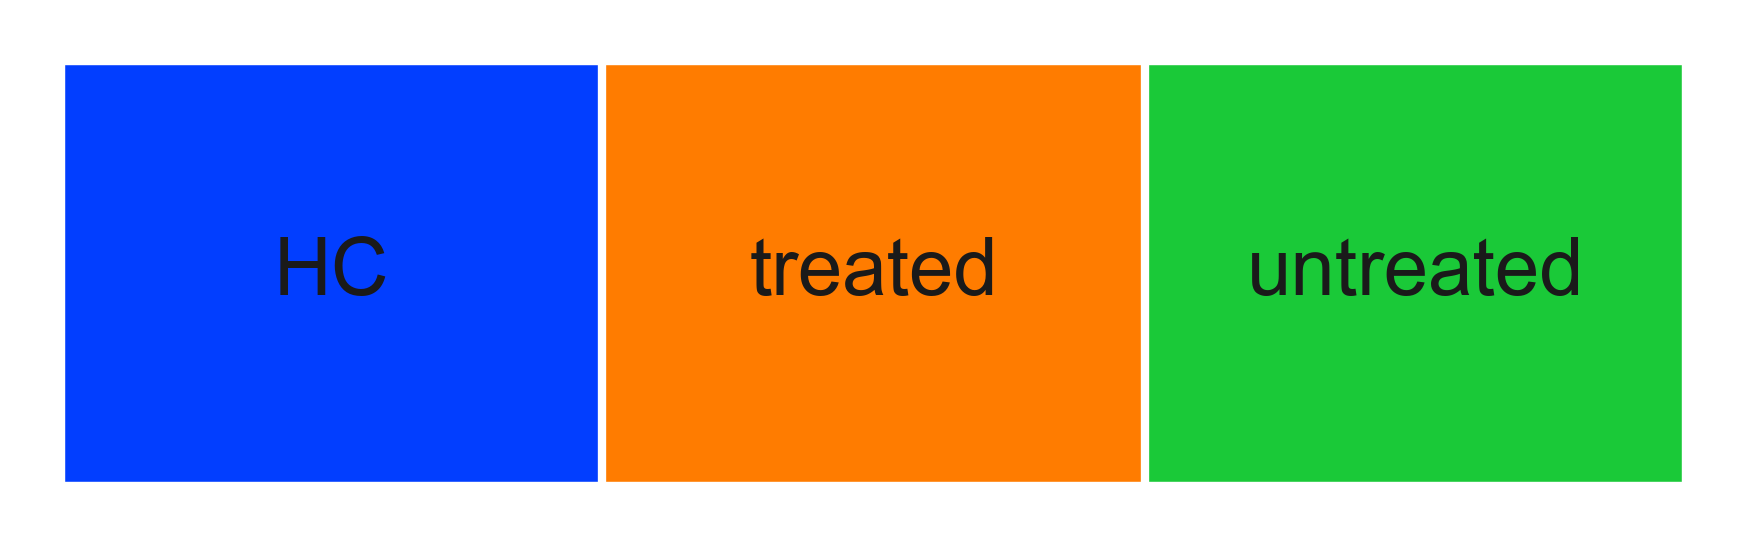

In [30]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)
plt.savefig("PBMC10k_cellType-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

In [31]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("PBMC10k_cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

# Further exploration of modules directly from the network inference output

In [32]:
adjacencies = pd.read_csv("./adj.csv", index_col=False)

In [33]:
adjacencies.shape

(2089798, 3)

In [41]:
(adjacencies.importance > 1).value_counts()

False    1890086
True      199712
Name: importance, dtype: int64

In [43]:
adjacencies[adjacencies.importance > 1].to_csv('./pdc_high_confidence_regulate.csv')

In [35]:
adjacencies.importance

0          1.058672e+02
1          8.875387e+01
2          6.750861e+01
3          6.722100e+01
4          6.660289e+01
               ...     
2089793    5.702568e-22
2089794    5.517018e-22
2089795    5.516864e-22
2089796    5.516795e-22
2089797    5.516548e-22
Name: importance, Length: 2089798, dtype: float64

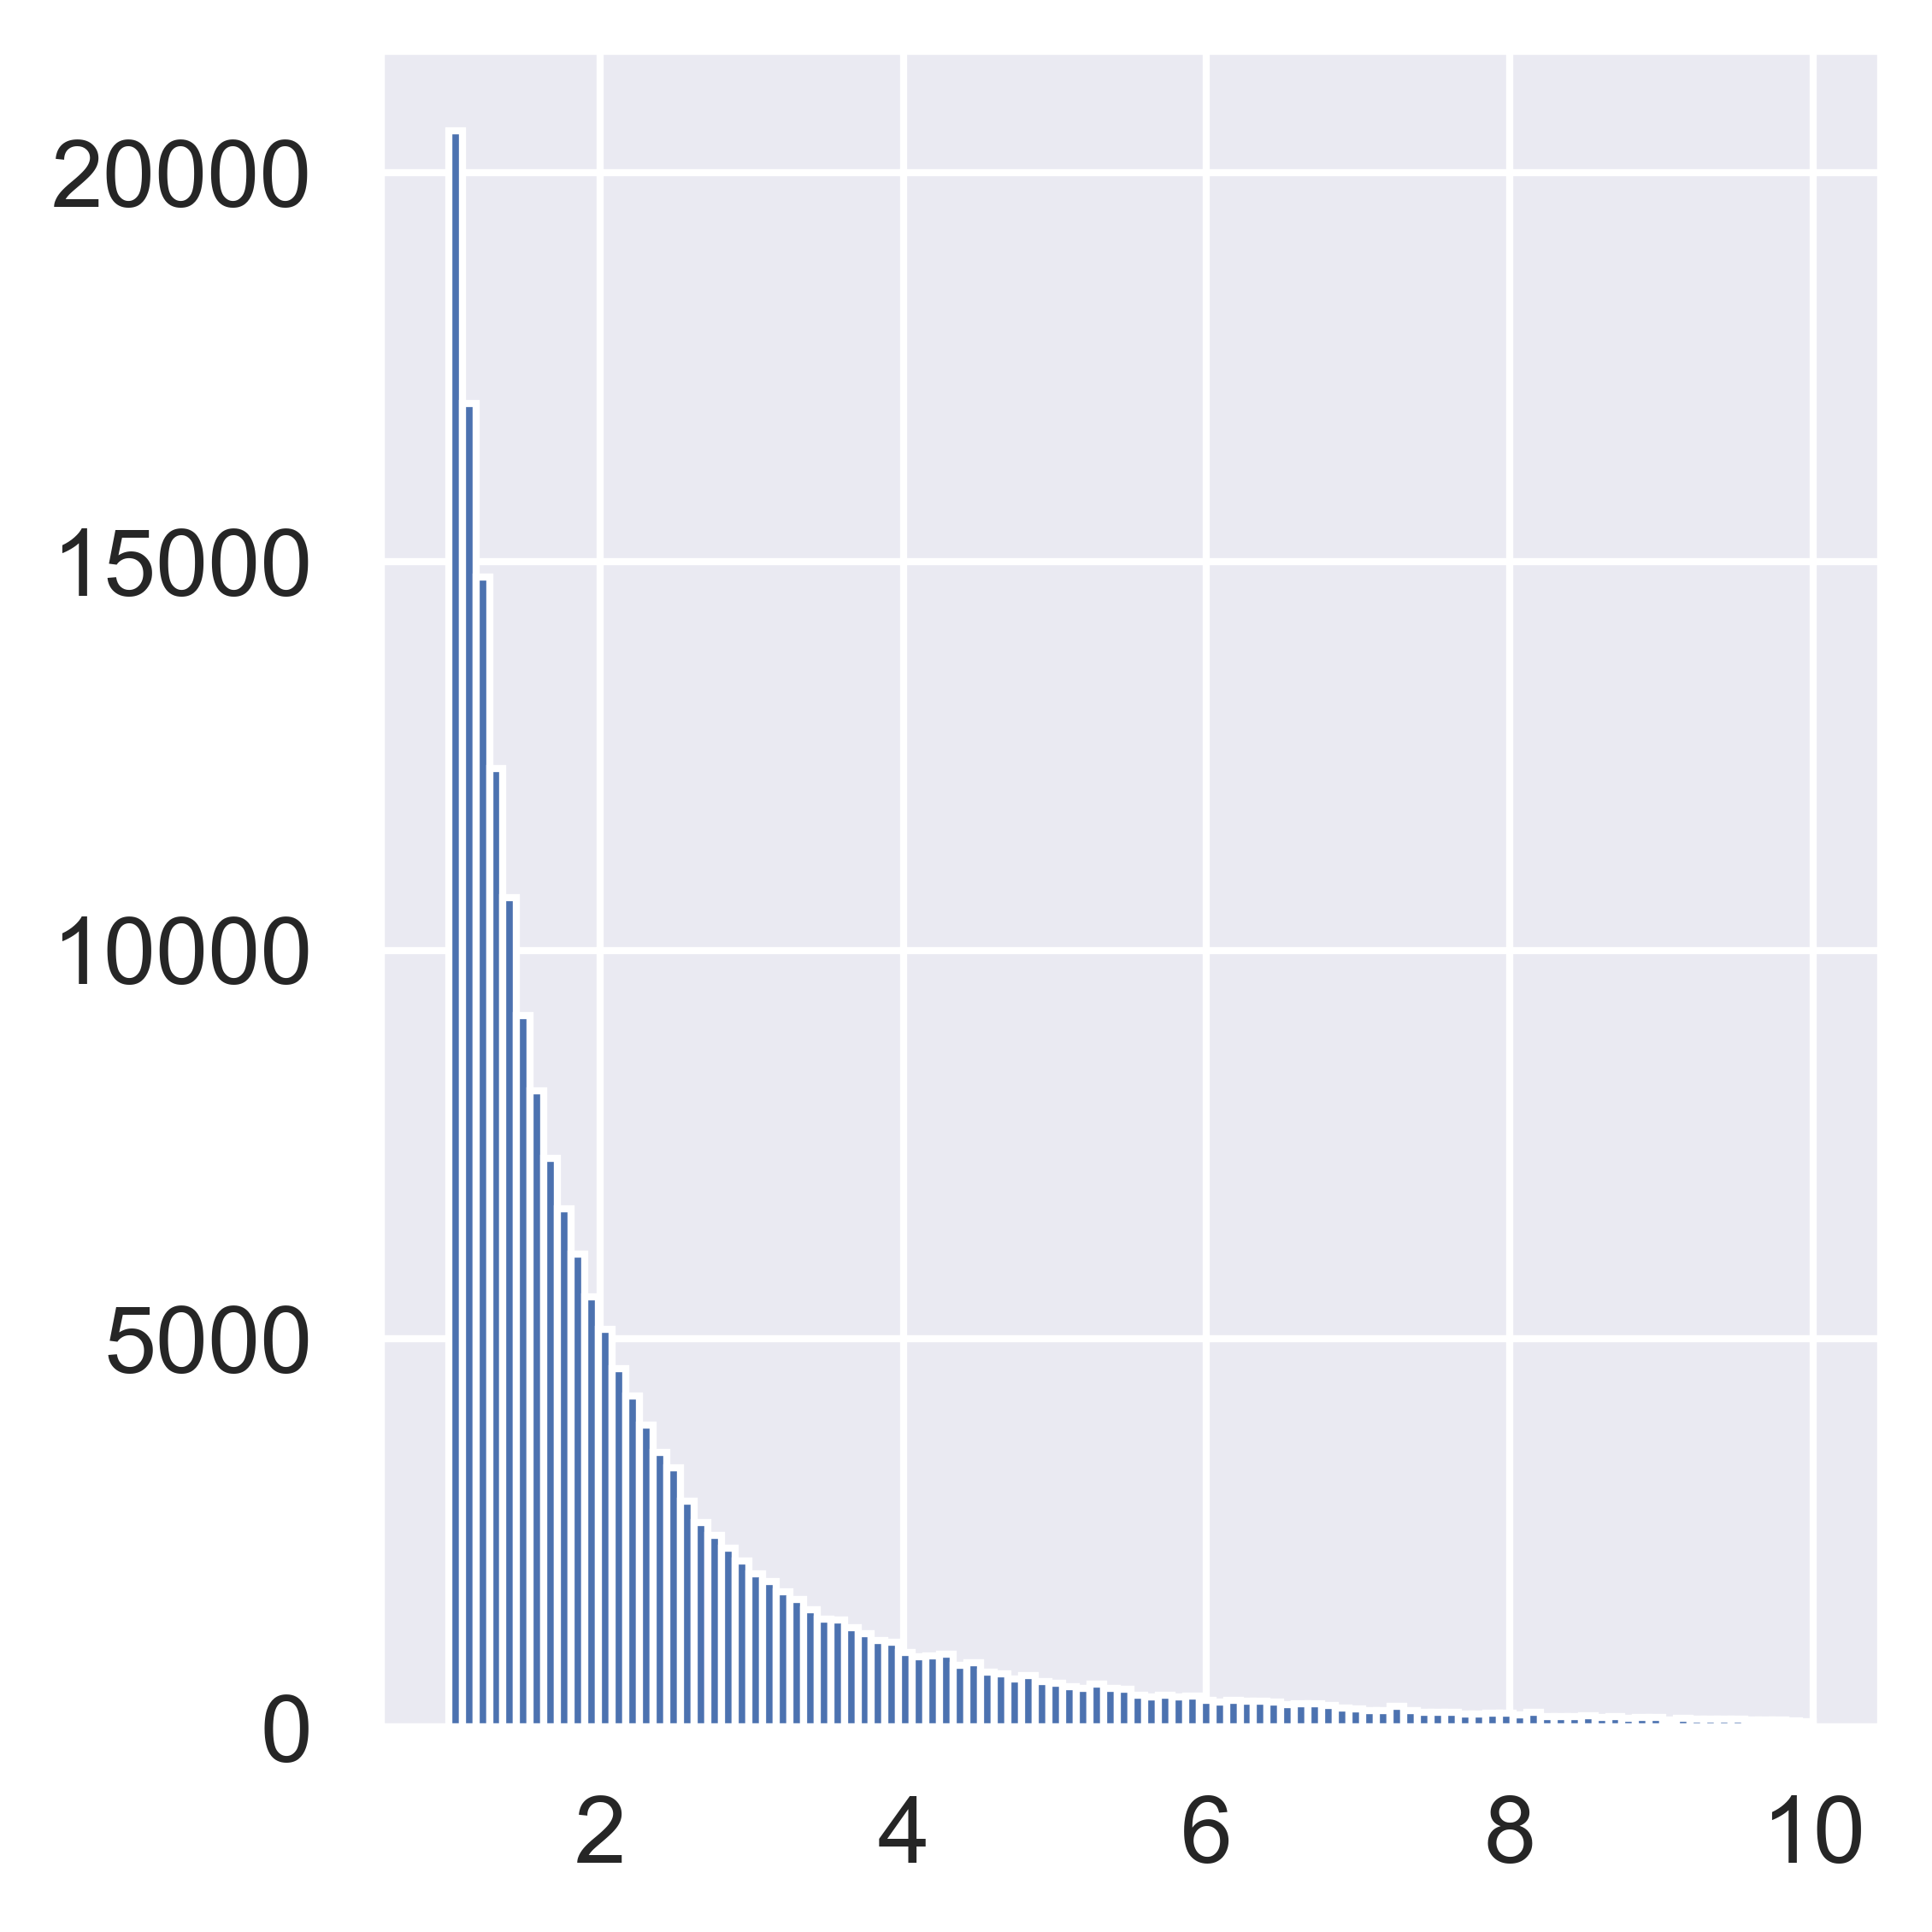

In [38]:
import matplotlib.pyplot as plt

plt.hist(adjacencies.importance,bins=100,range=(1,10))
plt.show() 

In [ ]:
from pyscenic.utils import modules_from_adjacencies
modules = list(modules_from_adjacencies(adjacencies, exprMat))

In [ ]:
regulons.keys()

In [ ]:
tf = 'STAT2'
tf_mods = [ x for x in modules if x.transcription_factor==tf ]

for i,mod in enumerate( tf_mods ):
    print( f'{tf} module {str(i)}: {len(mod.genes)} genes' )
print( f'{tf} regulon: {len(regulons[tf+"(+)"])} genes' )

In [ ]:
for i,mod in enumerate( tf_mods ):
    with open( tf+'_module_'+str(i)+'.txt', 'w') as f:
        for item in mod.genes:
            f.write("%s\n" % item)
            
with open( tf+'_regulon.txt', 'w') as f:
    for item in regulons[tf+'(+)']:
        f.write("%s\n" % item)

In [ ]:
# regulons['STAT2(+)']
# type(tf_mods[0].gene2weight)
for i in range(0,6):
    print(i)
    tmp  = pd.DataFrame({'gene' : tf_mods[i].genes  ,
                        'weight': tf_mods[i].weights })
    print(tmp[tmp['weight'] > 10].shape)
    tmp =  tmp[tmp['weight'] > 10]
    tmp.to_csv( tf+'_module_'+str(i)+'_filter_10.txt')

In [ ]:
dir()